<a href="https://colab.research.google.com/github/sarah-izzy/Predictive-influencer-marketing-system/blob/master/influencer_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

# Automatically get filenames
uploaded_files = list(uploaded.keys())

# Assign datasets safely
for file in uploaded_files:
    if 'roi' in file.lower():
        df_campaign = pd.read_csv(io.BytesIO(uploaded[file]))
    elif 'social' in file.lower():
        df_content = pd.read_csv(io.BytesIO(uploaded[file]))

print("Campaign dataset loaded:", df_campaign.shape)
print("Content dataset loaded:", df_content.shape)


Saving social_media_dataset.csv to social_media_dataset.csv
Saving influencer_marketing_roi.csv to influencer_marketing_roi.csv
Campaign dataset loaded: (150000, 10)
Content dataset loaded: (52214, 27)


In [ ]:
print(df_campaign.shape)
print(df_content.shape)

(150000, 10)
(52214, 27)


In [ ]:
# Fill missing text safely
df_content['content_description'] = df_content['content_description'].fillna('')
df_content['hashtags'] = df_content['hashtags'].fillna('')

# Engagement aggregation
df_content['total_engagements'] = (
    df_content['likes'] +
    df_content['shares'] +
    df_content['comments_count']
)

# Avoid divide-by-zero
df_content = df_content[df_content['follower_count'] > 0]


In [ ]:
# Engagement rate (better target)
df_content['engagement_rate'] = (
    df_content['total_engagements'] / df_content['follower_count']
)

# Log transform target
df_content['log_engagement_rate'] = np.log1p(df_content['engagement_rate'])


In [ ]:
categorical_cols = ['platform', 'content_type', 'content_category']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_content[col] = le.fit_transform(df_content[col].astype(str))
    label_encoders[col] = le


In [ ]:
# Combine text features
df_content['text_combined'] = (
    df_content['content_description'] + ' ' + df_content['hashtags']
)

tfidf = TfidfVectorizer(
    max_features=300,
    stop_words='english'
)

X_text = tfidf.fit_transform(df_content['text_combined'])


In [ ]:
numeric_features = df_content[
    [
        'platform',
        'content_type',
        'content_category',
        'content_length',
    ]
]

# Combine numeric + text
from scipy.sparse import hstack
X = hstack([numeric_features.values, X_text])

y = df_content['log_engagement_rate']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [ ]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Engagement Rate MAE (log): {mae}")
print(f"Engagement Rate R²: {r2}")


Engagement Rate MAE (log): 0.012642851437721328
Engagement Rate R²: -0.027878758522740243


In [ ]:
# Predict on full dataset
df_content['predicted_log_eng_rate'] = model.predict(X)

# Convert back from log scale
df_content['predicted_engagement_rate'] = np.expm1(
    df_content['predicted_log_eng_rate']
)


In [ ]:
# Normalize helper
def min_max(series):
    return (series - series.min()) / (series.max() - series.min())

df_content['score_engagement'] = min_max(df_content['predicted_engagement_rate'])
df_content['score_audience'] = min_max(np.log1p(df_content['follower_count']))
df_content['score_content'] = min_max(df_content['content_length'])

# Weighted influencer score
df_content['influencer_score'] = (
    0.5 * df_content['score_engagement'] +
    0.3 * df_content['score_audience'] +
    0.2 * df_content['score_content']
) * 100

df_content['influencer_score'] = df_content['influencer_score'].round(2)


In [ ]:
# ROI assumptions (same as earlier)
PRODUCT_SALE_PRICE = 40000.0
GROSS_PROFIT_MARGIN = 0.20
REVENUE_PER_SALE_NET = PRODUCT_SALE_PRICE * GROSS_PROFIT_MARGIN
COST_PER_THOUSAND_REACH = 20000.0
COST_PER_REACH = COST_PER_THOUSAND_REACH / 1000.0

# Estimate reach-based cost
df_content['estimated_campaign_cost'] = (
    df_content['follower_count'] * COST_PER_REACH
).clip(lower=1)

# Estimate sales from engagement
df_content['estimated_sales'] = (
    df_content['predicted_engagement_rate'] *
    df_content['follower_count'] * 0.02  # 2% conversion assumption
)

df_content['estimated_net_revenue'] = (
    df_content['estimated_sales'] * REVENUE_PER_SALE_NET
)

# ROI %
df_content['estimated_roi'] = (
    (df_content['estimated_net_revenue'] - df_content['estimated_campaign_cost']) /
    df_content['estimated_campaign_cost']
) * 100

df_content['estimated_roi'] = df_content['estimated_roi'].clip(-100, 500).round(2)


In [ ]:
platform_category_summary = (
    df_content
    .groupby(['platform', 'content_category'])
    .agg(
        avg_engagement_rate=('predicted_engagement_rate', 'mean'),
        avg_influencer_score=('influencer_score', 'mean'),
        avg_estimated_roi=('estimated_roi', 'mean'),
        creators=('creator_id', 'nunique')
    )
    .reset_index()
)

platform_category_summary.sort_values(
    by='avg_estimated_roi',
    ascending=False
).head(10)


,platform,content_category,avg_engagement_rate,avg_influencer_score,avg_estimated_roi,creators
9,3,0,0.013124,33.291993,-89.499937,2906
3,1,0,0.012951,33.097212,-89.673600,2888
10,3,1,0.012896,33.417260,-89.682851,2875
12,4,0,0.012843,33.337251,-89.725130,2947
14,4,2,0.012802,33.174476,-89.757850,1706
13,4,1,0.012798,33.519183,-89.761249,2941
8,2,2,0.012781,33.282962,-89.774431,1722
6,2,0,0.012739,33.511756,-89.808133,2915
1,0,1,0.012667,33.148166,-89.865519,2887
7,2,1,0.012665,33.360579,-89.867813,2863


In [ ]:
def analyze_influencer(name):
    subset = df_content[
        df_content['creator_name']
        .str.contains(name, case=False, na=False)
    ]

    if subset.empty:
        return "Influencer not found."

    summary = {
        "Creator Name": subset['creator_name'].iloc[0],
        "Platform": subset['platform'].iloc[0],
        "Follower Count": int(subset['follower_count'].mean()),
        "Predicted Engagement Rate": round(subset['predicted_engagement_rate'].mean(), 4),
        "Influencer Score": round(subset['influencer_score'].mean(), 2),
        "Estimated ROI (%)": round(subset['estimated_roi'].mean(), 2)
    }

    return summary


In [ ]:
analyze_influencer("julia34")


{'Creator Name': 'julia34',
 'Platform': np.int64(3),
 'Follower Count': 341885,
 'Predicted Engagement Rate': np.float64(0.0123),
 'Influencer Score': np.float64(28.36),
 'Estimated ROI (%)': np.float64(-90.14)}

In [ ]:
# Inverse transform using the saved LabelEncoder
df_content['platform_name'] = label_encoders['platform'].inverse_transform(df_content['platform'])
df_content['content_category_name'] = label_encoders['content_category'].inverse_transform(df_content['content_category'])

# Update the influencer analysis function to show platform names
def analyze_influencer_decoded(name):
    subset = df_content[df_content['creator_name'].str.contains(name, case=False, na=False)]
    if subset.empty:
        return "Influencer not found."

    summary = {
        "Creator Name": subset['creator_name'].iloc[0],
        "Platform": subset['platform_name'].iloc[0],
        "Follower Count": int(subset['follower_count'].mean()),
        "Predicted Engagement Rate": round(subset['predicted_engagement_rate'].mean(), 4),
        "Influencer Score": round(subset['influencer_score'].mean(), 2),
        "Estimated ROI (%)": round(subset['estimated_roi'].mean(), 2)
    }

    return summary


In [ ]:
analyze_influencer_decoded("julia34")


{'Creator Name': 'julia34',
 'Platform': 'TikTok',
 'Follower Count': 341885,
 'Predicted Engagement Rate': np.float64(0.0123),
 'Influencer Score': np.float64(28.36),
 'Estimated ROI (%)': np.float64(-90.14)}

In [ ]:
def compare_influencers(names):
    subset = df_content[df_content['creator_name'].str.lower().isin([n.lower() for n in names])]
    if subset.empty:
        return "No influencers found."

    comparison = subset.groupby('creator_name').agg(
        Platform=('platform_name', 'first'),
        Follower_Count=('follower_count', 'mean'),
        Predicted_Engagement_Rate=('predicted_engagement_rate', 'mean'),
        Influencer_Score=('influencer_score', 'mean'),
        Estimated_ROI=('estimated_roi', 'mean')
    ).reset_index()

    # Round numeric columns
    comparison['Predicted_Engagement_Rate'] = comparison['Predicted_Engagement_Rate'].round(4)
    comparison['Influencer_Score'] = comparison['Influencer_Score'].round(2)
    comparison['Estimated_ROI'] = comparison['Estimated_ROI'].round(2)

    return comparison


In [ ]:
compare_influencers(['julia34', 'wrightrandy'])

,creator_name,Platform,Follower_Count,Predicted_Engagement_Rate,Influencer_Score,Estimated_ROI
0,julia34,TikTok,341885.0,0.0123,28.36,-90.14
1,wrightrandy,TikTok,629691.0,0.0123,37.15,-90.16


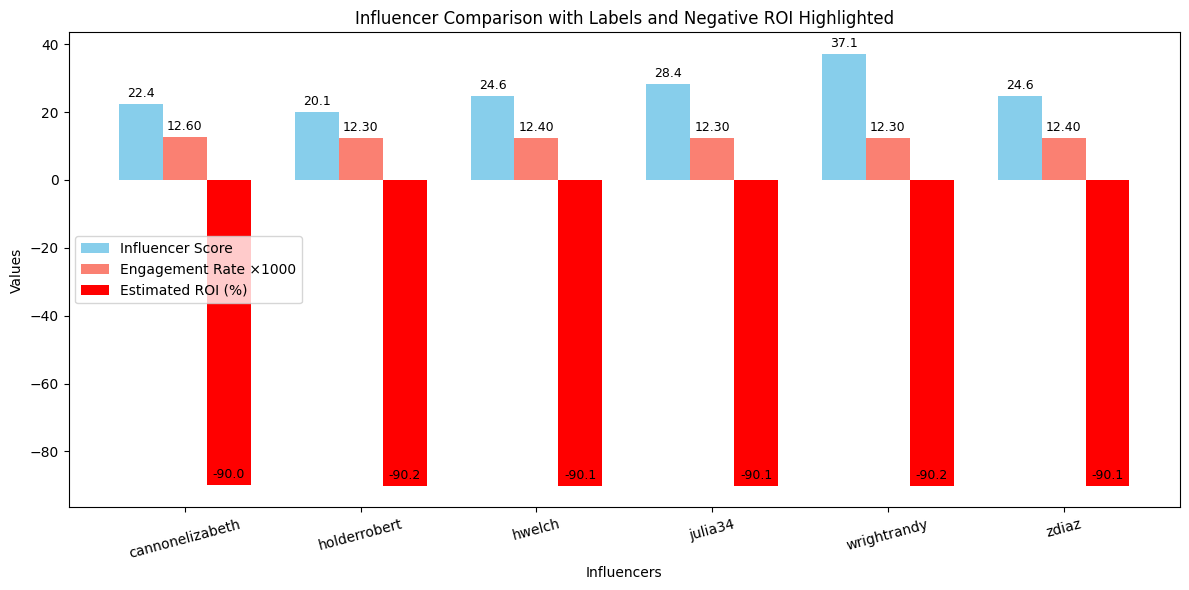

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_influencers_with_labels(names):
    comparison = compare_influencers(names)

    if isinstance(comparison, str):
        return comparison

    x = np.arange(len(comparison))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12,6))

    # Bars for Influencer Score
    bars_score = ax.bar(x - width, comparison['Influencer_Score'], width, label='Influencer Score', color='skyblue')

    # Bars for Engagement Rate (scaled ×1000)
    bars_eng = ax.bar(x, comparison['Predicted_Engagement_Rate']*1000, width, label='Engagement Rate ×1000', color='salmon')

    # Bars for ROI with color coding
    roi_colors = ['red' if roi < 0 else 'green' for roi in comparison['Estimated_ROI']]
    bars_roi = ax.bar(x + width, comparison['Estimated_ROI'], width, label='Estimated ROI (%)', color=roi_colors)

    # Add numeric labels on top of bars
    for bar in bars_score:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    for bar in bars_eng:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    for bar, roi in zip(bars_roi, comparison['Estimated_ROI']):
        height = bar.get_height()
        ax.annotate(f'{roi:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    # Labels and title
    ax.set_xlabel('Influencers')
    ax.set_ylabel('Values')
    ax.set_title('Influencer Comparison with Labels and Negative ROI Highlighted')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison['creator_name'])
    ax.legend()

    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_influencers_with_labels(['julia34', 'cannonelizabeth', 'wrightrandy', 'holderrobert', 'zdiaz', 'hwelch'])


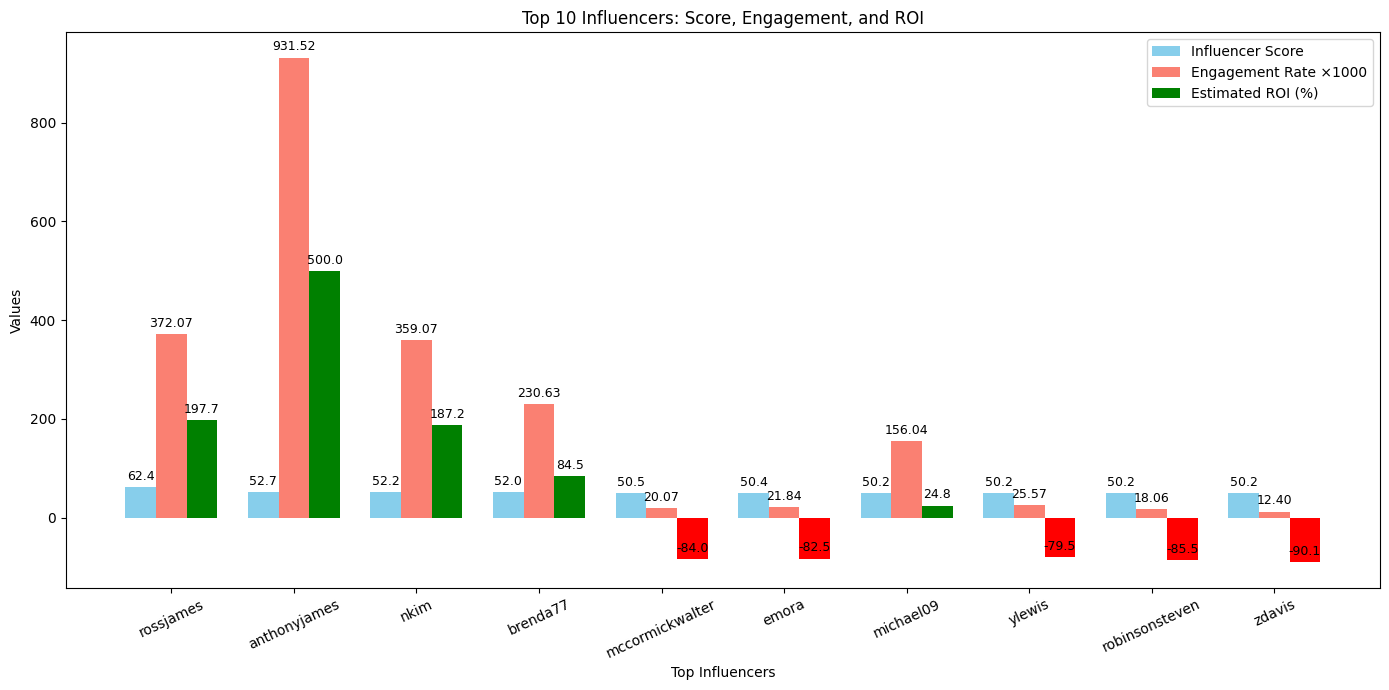

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
45237,rossjames,TikTok,828912,0.372073,62.42,197.66
12562,anthonyjames,Instagram,1023,0.931518,52.73,500.00
45855,nkim,YouTube,290505,0.359065,52.23,187.25
16637,brenda77,Bilibili,930369,0.230628,51.97,84.50
33472,mccormickwalter,TikTok,967350,0.020068,50.47,-83.95
43545,emora,TikTok,939127,0.021844,50.44,-82.52
42041,michael09,YouTube,267549,0.156039,50.18,24.83
7445,ylewis,YouTube,844409,0.025567,50.18,-79.55
28199,robinsonsteven,Bilibili,927483,0.018065,50.18,-85.55
48719,zdavis,TikTok,999052,0.012397,50.16,-90.08


In [ ]:
def top_n_influencer_report(n=10):
    # Sort by Influencer Score descending
    top_influencers = df_content.sort_values(by='influencer_score', ascending=False).head(n)

    x = np.arange(len(top_influencers))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14,7))

    # Bars for Influencer Score
    bars_score = ax.bar(x - width, top_influencers['influencer_score'], width, label='Influencer Score', color='skyblue')

    # Bars for Engagement Rate (scaled ×1000)
    bars_eng = ax.bar(x, top_influencers['predicted_engagement_rate']*1000, width, label='Engagement Rate ×1000', color='salmon')

    # Bars for ROI with color coding
    roi_colors = ['red' if roi < 0 else 'green' for roi in top_influencers['estimated_roi']]
    bars_roi = ax.bar(x + width, top_influencers['estimated_roi'], width, label='Estimated ROI (%)', color=roi_colors)

    # Add numeric labels
    for bar in bars_score:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar in bars_eng:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar, roi in zip(bars_roi, top_influencers['estimated_roi']):
        height = bar.get_height()
        ax.annotate(f'{roi:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Labels and title
    ax.set_xlabel('Top Influencers')
    ax.set_ylabel('Values')
    ax.set_title(f'Top {n} Influencers: Score, Engagement, and ROI')
    ax.set_xticks(x)
    ax.set_xticklabels(top_influencers['creator_name'], rotation=25)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Return DataFrame for reference
    return top_influencers[['creator_name', 'platform_name', 'follower_count',
                            'predicted_engagement_rate', 'influencer_score', 'estimated_roi']]

# Example Usage
top_n_report = top_n_influencer_report(n=10)
top_n_report


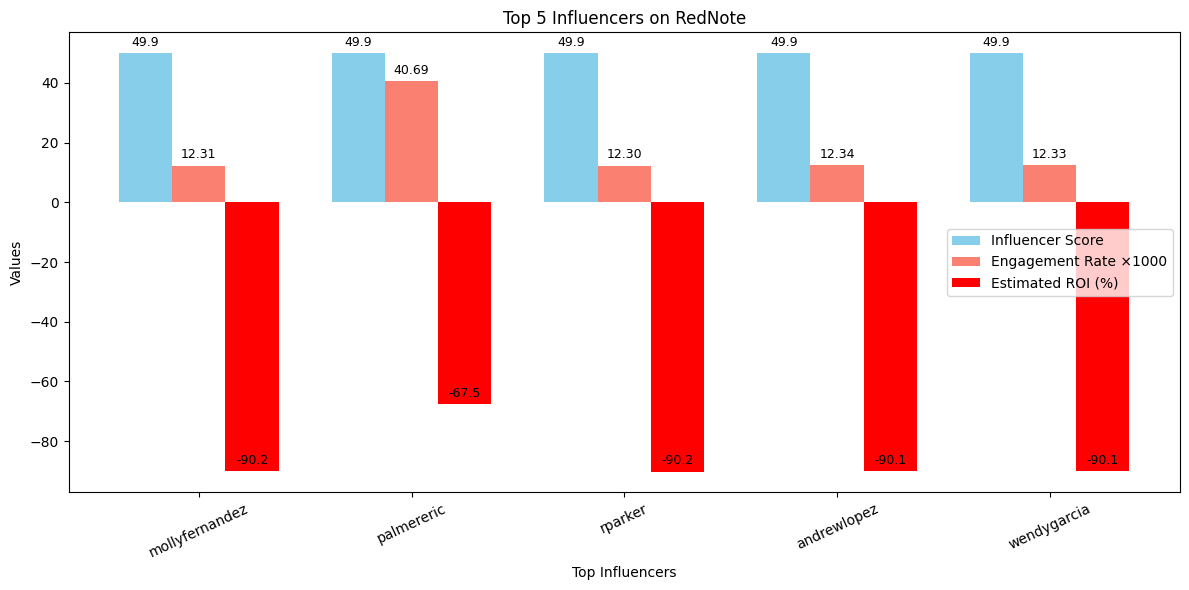

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
43286,mollyfernandez,RedNote,997496,0.012314,49.91,-90.15
11958,palmereric,RedNote,656380,0.040685,49.90,-67.45
20718,rparker,RedNote,965973,0.012299,49.88,-90.16
11588,andrewlopez,RedNote,933055,0.012335,49.86,-90.13
14093,wendygarcia,RedNote,945676,0.012332,49.85,-90.13


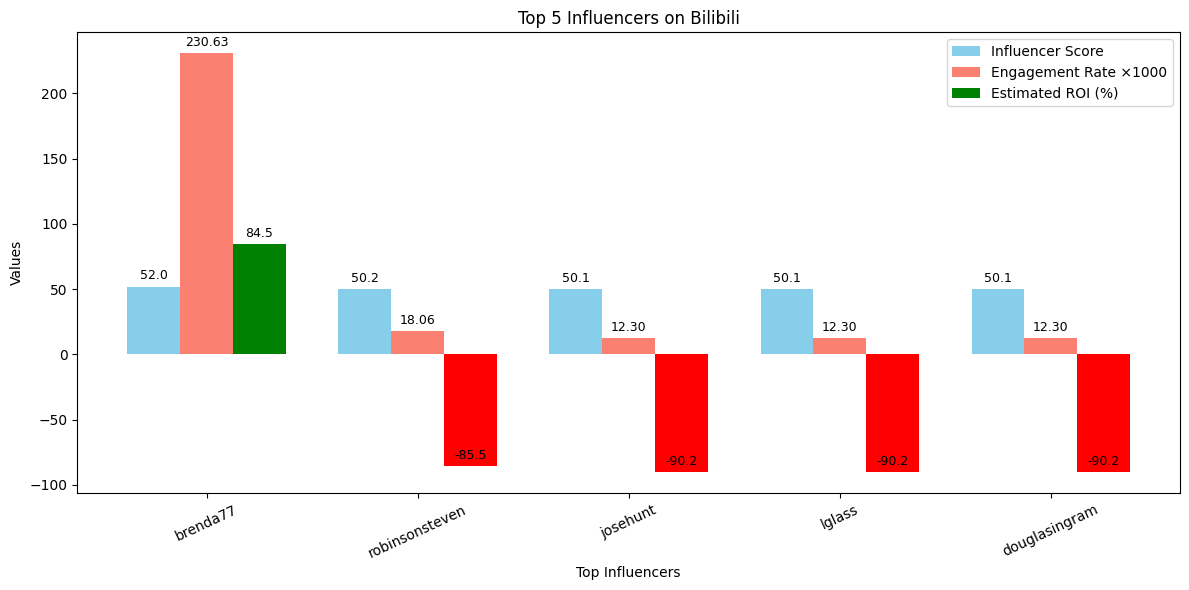

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
16637,brenda77,Bilibili,930369,0.230628,51.97,84.50
28199,robinsonsteven,Bilibili,927483,0.018065,50.18,-85.55
44309,josehunt,Bilibili,996737,0.012299,50.15,-90.16
34756,lglass,Bilibili,990682,0.012299,50.12,-90.16
41641,douglasingram,Bilibili,994968,0.012299,50.11,-90.16


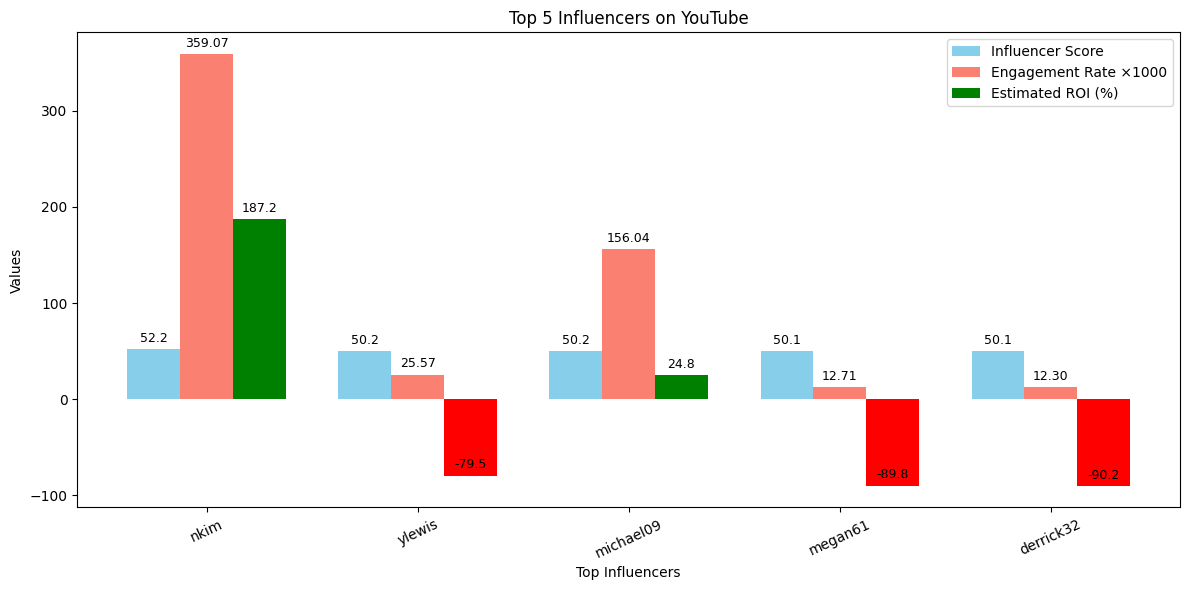

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
45855,nkim,YouTube,290505,0.359065,52.23,187.25
7445,ylewis,YouTube,844409,0.025567,50.18,-79.55
42041,michael09,YouTube,267549,0.156039,50.18,24.83
13076,megan61,YouTube,971868,0.012706,50.09,-89.83
46079,derrick32,YouTube,995179,0.012299,50.07,-90.16


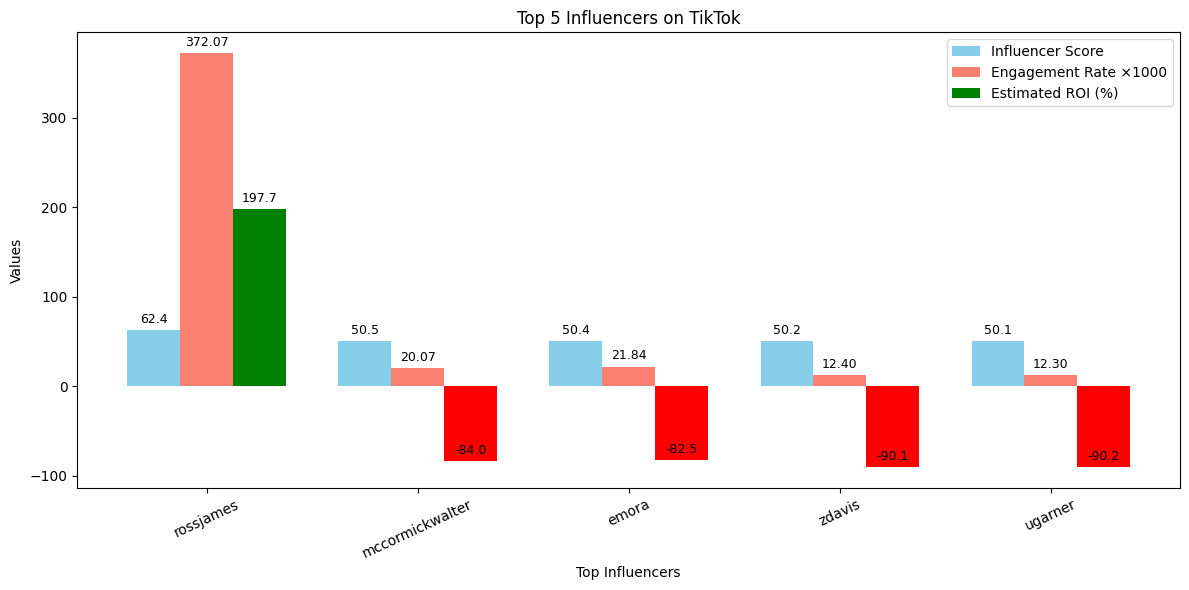

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
45237,rossjames,TikTok,828912,0.372073,62.42,197.66
33472,mccormickwalter,TikTok,967350,0.020068,50.47,-83.95
43545,emora,TikTok,939127,0.021844,50.44,-82.52
48719,zdavis,TikTok,999052,0.012397,50.16,-90.08
8909,ugarner,TikTok,984159,0.012299,50.06,-90.16


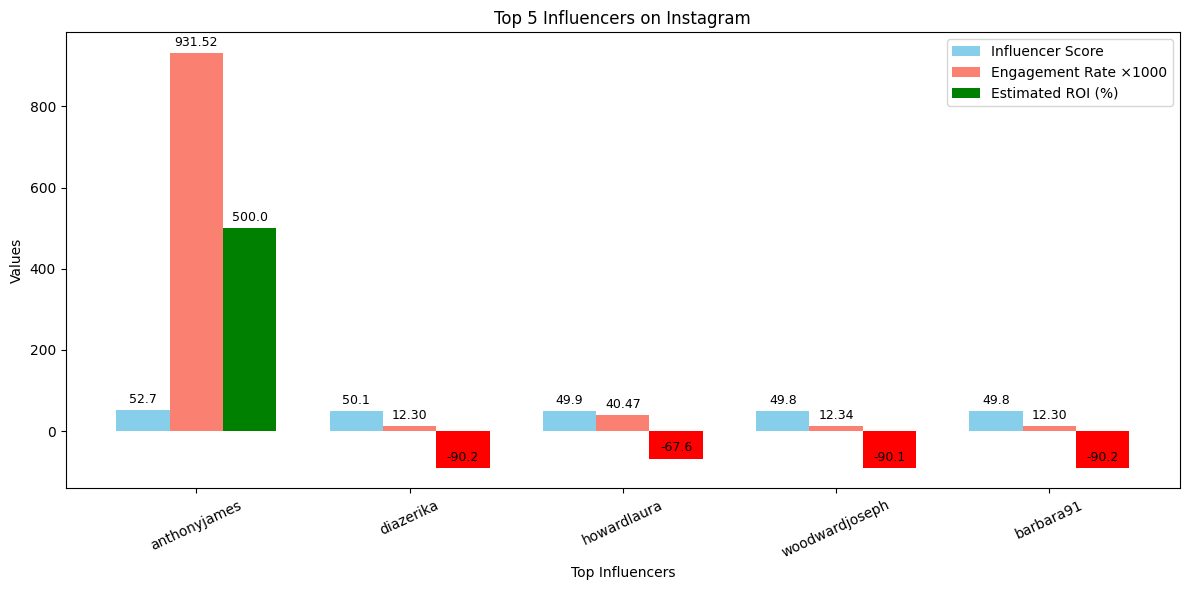

,creator_name,platform_name,follower_count,predicted_engagement_rate,influencer_score,estimated_roi
12562,anthonyjames,Instagram,1023,0.931518,52.73,500.00
5151,diazerika,Instagram,993656,0.012301,50.14,-90.16
29334,howardlaura,Instagram,681636,0.040465,49.85,-67.63
37584,woodwardjoseph,Instagram,944052,0.012335,49.78,-90.13
26768,barbara91,Instagram,988783,0.012299,49.77,-90.16


In [ ]:
def platform_top_n_influencer_report(n=5):
    platforms = df_content['platform_name'].unique()

    for platform in platforms:
        platform_df = df_content[df_content['platform_name'] == platform]
        top_platform = platform_df.sort_values(by='influencer_score', ascending=False).head(n)

        x = np.arange(len(top_platform))
        width = 0.25

        fig, ax = plt.subplots(figsize=(12,6))

        # Influencer Score bars
        bars_score = ax.bar(x - width, top_platform['influencer_score'], width, label='Influencer Score', color='skyblue')

        # Engagement Rate bars (scaled ×1000)
        bars_eng = ax.bar(x, top_platform['predicted_engagement_rate']*1000, width, label='Engagement Rate ×1000', color='salmon')

        # ROI bars with color coding
        roi_colors = ['red' if roi < 0 else 'green' for roi in top_platform['estimated_roi']]
        bars_roi = ax.bar(x + width, top_platform['estimated_roi'], width, label='Estimated ROI (%)', color=roi_colors)

        # Numeric labels
        for bar in bars_score:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        for bar in bars_eng:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        for bar, roi in zip(bars_roi, top_platform['estimated_roi']):
            height = bar.get_height()
            ax.annotate(f'{roi:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

        # Labels and title
        ax.set_xlabel('Top Influencers')
        ax.set_ylabel('Values')
        ax.set_title(f'Top {n} Influencers on {platform}')
        ax.set_xticks(x)
        ax.set_xticklabels(top_platform['creator_name'], rotation=25)
        ax.legend()

        plt.tight_layout()
        plt.show()

        # Optional: return DataFrame for reference
        display(top_platform[['creator_name', 'platform_name', 'follower_count',
                              'predicted_engagement_rate', 'influencer_score', 'estimated_roi']])

# Example usage
platform_top_n_influencer_report(n=5)
